<a href="https://colab.research.google.com/github/AKIYAMA-Keito/Colab-repo/blob/main/AWP_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np

Step1 Tensorflowチュートリアル4から引用

version2


データセットを読み込んで正規化する．

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
random_index_train = np.array(range(len(x_train)))
np.random.shuffle(random_index_train)
x_train = x_train[random_index_train][:1000]
y_train = y_train[random_index_train][:1000]
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

データセットをシャッフルしてバッチ化する．

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).batch(1000)
test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)
).batch(1000)

CNNモデルを定義しインスタンスを取り出す．

In [4]:
class CNNModel(Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation = "relu")
        self.flatten = Flatten()
        self.d1 = Dense(128, activation = "relu")
        self.d2 = Dense(10)
    
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

model = CNNModel()

損失関数とoptmizerを選択する．

In [5]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam()

損失関数とoptimizerの尺度評価のための関数を導入する．

In [6]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

モデルを訓練するための関数train_stepを定義する．
予測値と正解ラベルの間の損失関数の勾配を最適化する．

In [7]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training = True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

モデルをテストするための関数test_stepを定義する．

In [8]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training = False)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

学習を実行してテストし，結果を出力する．

In [9]:
EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for train_images, train_labels in train_ds:
        train_step(train_images, train_labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Loss: 2.322615623474121, Accuracy: 8.90000057220459, Test Loss: 1.85744309425354, Test Accuracy: 53.02000045776367
Epoch 2, Loss: 1.8357914686203003, Accuracy: 55.29999542236328, Test Loss: 1.3783245086669922, Test Accuracy: 70.1500015258789
Epoch 3, Loss: 1.348958134651184, Accuracy: 72.5999984741211, Test Loss: 1.0474377870559692, Test Accuracy: 76.06999969482422


AWPのアルゴリズムを記述する．
まず，学習済みのmodelから重みを取り出してvを加えて再設定する．

In [10]:
weights = model.get_weights()
ordinary_weights = weights
v_array = []
for w in weights:
  v = 0.00002 * np.random.rand() - 0.00001
  v_array.append(tf.fill(w.shape, v))

Step2

In [11]:
# @tf.function
def adversary(dataset, additive_weights, eps1 = 1, eta1 = 0.1, iterate_num = 5):
    weights = model.get_weights()
    new_weights = []
    for w, v in zip(weights, additive_weights):
      new_weights.append(w + v)
    model.set_weights(new_weights)

    adversarial_image_list = []
    # eps1 = 1
    # eta1 = 0.1
    for (images, labels) in dataset:
      for (image, label) in zip(images, labels):
        image = tf.Variable([image])

        initial_noise = 2 * eps1 * np.random.rand() - eps1
        image_dashed = tf.add(image, initial_noise)

        # この書き方でも，initial_noiseが一様に入ってしまっている．
        # tf.Variableで1次元追加しているから，より内側のループを作らないといけないよ
        # image_dashed_list = []
        # for image_0 in image:
        #   for image_h in image_0:
        #     for image_v in image_h:
        #       for image_pixel in image_v:
        #         initial_noise = 2 * eps1 * np.random.rand() - eps1
        #         image_pixel_dashed = tf.add(image_pixel, initial_noise)
        # image_dashed_list.append(image_pixel_dashed)
        # # image_dashed = np.array(image_dashed_list)
        # image_dashed = tf.convert_to_tensor(image_dashed_list)
        # print(image_dashed.numpy())

        for j in range(iterate_num):
          with tf.GradientTape() as tape:
            tape.watch(image_dashed)
            prediction = model(image_dashed, training = True)
            loss = loss_object(label, prediction)
          gradients = tape.gradient(loss, image_dashed)
          image_med = tf.add(image_dashed, tf.multiply(eta1, gradients))
          difference = tf.subtract(image_med, image)
          if tf.norm(difference) <= eps1:
            image_dashed = image_med 
          else:
            image_dashed = difference
            image_dashed = tf.multiply(image_dashed, eps1)
            image_dashed = tf.divide(image_dashed, tf.norm(difference))
            image_dashed = tf.add(image_dashed, image)
        adversarial_image_list.append(image_dashed[0])
        adversarial_image = np.array(adversarial_image_list)

    return adversarial_image

In [12]:
x_adversarial = adversary(train_ds, v_array)

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

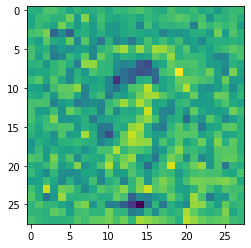

9


In [14]:
# for i in range(10):
plt.imshow(np.squeeze(x_adversarial[0] - x_train[0]))
plt.show()
print(y_train[0])

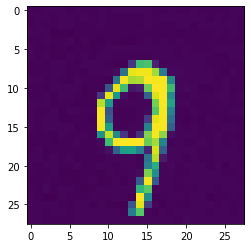

9


In [15]:
plt.imshow(np.squeeze(x_adversarial[0]))
plt.show()
print(y_train[0])

In [16]:
# %matplotlib inline
# for i in range(10):
#   plt.imshow(np.squeeze(x_adversarial[i]))
#   plt.show()
#   print(y_train[i])

Step3

In [17]:
adversarial_ds = tf.data.Dataset.from_tensor_slices(
    (x_adversarial, y_train)
).batch(100)

In [18]:
def calculate_loss(dataset, batch_size = 100):
  batch_size = 100
  loss_sum = 0.0
  for (images, labels) in adversarial_ds:
    predictions = model(images, training = True)
    loss = loss_object(labels, predictions)
    loss_sum_batch = loss * batch_size
    loss_sum = tf.add(loss_sum_batch, loss_sum)
  average_loss = tf.divide(loss_sum, 1000)
  return average_loss

Step4

In [19]:
def calculate_weights_norm(weights):
  w_flat = np.ndarray([])
  for w in weights:
    w_reshape = tf.reshape(w, [-1])
    w_flat = np.hstack([w_flat, w_reshape])
  w_fro = np.linalg.norm(w_flat)
  return w_fro

In [20]:
value1 = calculate_weights_norm(ordinary_weights)
print(value1)

16.9052696818999


In [21]:
def flatness(dataset, weights,  v_fixed, eps2 = 1, eta2 = 0.1, batch_size = 1000, iterate_num = 5):
  # vの初期値を，step2で固定したvに設定する．
  v_updated = v_fixed

  for i in range(iterate_num):

    # 重みをw + (現在の)vに設定する　　ここから
    current_weights = []
    for layer_weights, v in zip(weights, v_updated):
      current_layer_weight = tf.add(layer_weights, v)
      current_weights.append(current_layer_weight)
    model.set_weights(current_weights)
    # 重みをw + (現在の)vに設定する　　ここまで

    # gradientの計算　　ここから
    with tf.GradientTape() as tape:
      loss = calculate_loss(dataset)
      # loss = tf.multiply(-1.0, calculate_loss(dataset))
    gradients = tape.gradient(loss, model.trainable_variables)
    #　計算できているし，悪い値ではない．
    # gradientの計算　　ここまで

    # gradientのノルムの計算　　ここから
    gradients_flat = []
    for g in gradients:
      g_reshape = tf.reshape(g, [-1])
      gradients_flat = np.hstack([gradients_flat, g_reshape])
    gradients_norm = np.linalg.norm(gradients_flat)
    # ループを経るごとに値が大きくなり過ぎている？
    # gradientのノルムの計算　　ここまで

    # 勾配降下の実行　　ここから
    v_difference = []
    for g, v in zip(gradients, v_updated):
      g = tf.divide(g, gradients_norm)
      g = tf.multiply(g, calculate_weights_norm(weights))
      g = tf.multiply(eta2, g)
      v_med = tf.add(v, g)
    # 勾配降下の実行　　ここまで

    # (現在の)vと(元の重み)wの差分と，　そのノルムを計算　　ここから
      v_difference.append(v_med)
    v_difference_flat = np.ndarray([])
    for v_flat in v_difference:
      v_flat_reshape = tf.reshape(v_flat, [-1])
      v_difference_flat = np.hstack([v_difference_flat, v_flat_reshape])
    v_difference_norm = np.linalg.norm(v_difference_flat)
    # (現在の)vと(元の重み)wの差分と，　そのノルムを計算　　ここまで

    # 射影の実行　　ここから
    if v_difference_norm <= eps2:
      v_hat = v_med 
    else:
      v_hat = v_difference
      for v_hat_med in v_hat:
        v_hat_med = tf.multiply(v_hat_med, eps2)
        v_hat_med = tf.divide(v_hat_med, v_difference_norm)
    v_updated = v_hat
    # 計算できているし，悪い値ではない．
    # 射影の実行　　ここまで

  return v_updated

In [22]:
new_v = flatness(adversarial_ds, ordinary_weights, v_array)

In [23]:
# # eps2 = 1
# # eta2 = 0.1
# # batch_size = 1000

# v_updated = v_array
# # vの初期値を，step2で固定したvに設定する．

# for i in range(5):

#   # 重みをw + (現在の)vに設定する　　ここから
#   current_weights = []
#   # print(current_weights)
#   for layer_weights, v in zip(ordinary_weights, v_updated):
#     current_layer_weight = tf.add(layer_weights, v)
#     current_weights.append(current_layer_weight)
#   # print(current_weights)
#   model.set_weights(current_weights)
#   # 重みをw + (現在の)vに設定する　　ここまで

#   # gradientの計算　　ここから
#   with tf.GradientTape() as tape:
#     loss = calculate_loss(adversarial_ds)
#     # loss = tf.multiply(-1.0, calculate_loss(adversarial_ds))
#     print(loss)
#   gradients = tape.gradient(loss, model.trainable_variables)
#   # print(gradients)
#   #　計算できているし，悪い値ではない．
#   # gradientの計算　　ここまで

#   # gradientのノルムの計算　　ここから
#   gradients_flat = []
#   for g in gradients:
#     g_reshape = tf.reshape(g, [-1])
#     # print(g_reshape)
#     gradients_flat = np.hstack([gradients_flat, g_reshape])
#     # print(gradients_flat)
#   gradients_norm = np.linalg.norm(gradients_flat)
#   # print(gradients_norm)
#   # print(gradients_flat)
#   # print(gradients_norm)
#   # ループを経るごとに値が大きくなり過ぎている？
#   # gradientのノルムの計算　　ここまで

#   # 勾配降下の実行　　ここから
#   v_difference = []
#   for g, v in zip(gradients, v_updated):
#     g = tf.divide(g, gradients_norm)
#     g = tf.multiply(g, calculate_weights_norm(ordinary_weights))
#     g = tf.multiply(eta2, g)
#     v_med = tf.add(v, g)
#   # 勾配降下の実行　　ここまで

#   # (現在の)vと(元の重み)wの差分と，　そのノルムを計算　　ここから
#     v_difference.append(v_med)
#   v_difference_flat = np.ndarray([])
#   for v_flat in v_difference:
#     v_flat_reshape = tf.reshape(v_flat, [-1])
#     # print(g_reshape.shape)
#     v_difference_flat = np.hstack([v_difference_flat, v_flat_reshape])
#   v_difference_norm = np.linalg.norm(v_difference_flat)
#   # (現在の)vと(元の重み)wの差分と，　そのノルムを計算　　ここまで

#   # 射影の実行　　ここから
#   if v_difference_norm <= eps2:
#     v_hat = v_med 
#   else:
#     v_hat = v_difference
#     for v_hat_med in v_hat:
#       v_hat_med = tf.multiply(v_hat_med, eps2)
#       v_hat_med = tf.divide(v_hat_med, v_difference_norm)
#   v_updated = v_hat
#   # print(v_updated)
#   # 計算できているし，悪い値ではない．
#   # 射影の実行　　ここまで

Step5

In [24]:
def update(dataset, weights, v_updated, eta3 = 1):

  # 重みをw + (step4で決めた)vに設定する　　ここから
  current_weights = []
  for layer_weights, v in zip(weights, v_updated):
    current_layer_weight = tf.add(layer_weights, v)
    current_weights.append(current_layer_weight)
  model.set_weights(current_weights)
  # 計算できている．
  # 重みをw + (step4で決めた)vに設定する　　ここまで

  # gradientの計算　　ここから
  with tf.GradientTape() as tape:
    loss = calculate_loss(dataset)
  gradients = tape.gradient(loss, model.trainable_variables)
  # 計算できているが，値が大きい．
  # gradientの計算　　ここまで

  # 勾配降下の実行　　ここから
  w_hat = []
  for wu, g in zip(weights, gradients):
    g_med = tf.multiply(eta3, g)
    wu = tf.subtract(wu, g_med)
    w_hat.append(wu)
  weights_updated = w_hat
  # 勾配降下の実行　　ここまで
  return weights_updated

In [25]:
new_weights = update(adversarial_ds, ordinary_weights, new_v)
print(new_weights)
model.set_weights(new_weights)
ordinary_weights = model.get_weights()

[<tf.Tensor: shape=(3, 3, 1, 32), dtype=float32, numpy=
array([[[[ 1.13265388e-01, -2.40081229e+09, -1.03323668e-01,
           1.34714678e-01, -1.10210406e+09,  4.08577360e-02,
          -1.08190694e+09,  8.22002217e-02, -8.10620487e-02,
          -1.27651766e-01, -1.29024550e-01, -5.26114516e-02,
           9.76892784e-02, -9.70370602e-03, -7.55913034e-02,
           8.16369876e-02, -1.86071023e-02, -3.47253233e-02,
           1.21294968e-01, -9.59178656e-02, -1.37923285e-01,
           1.15387835e-01, -6.36961535e-02,  7.90769756e-02,
           7.14031085e-02,  6.04726700e-03, -2.94436514e-02,
           3.47561277e-02, -1.91848874e+00,  7.04557180e-01,
           4.86229360e-03,  5.71990728e-01]],

        [[ 1.03717513e-01, -2.41400499e+09,  1.05212919e-01,
          -8.18319917e-02, -1.10825549e+09,  8.91594738e-02,
          -1.08805786e+09,  7.78152272e-02, -6.07596673e-02,
          -3.43603939e-02,  1.16285706e+00, -4.94831167e-02,
           1.09498799e-01,  5.59974797e-02,

再テストの実行

In [26]:
EPOCHS = 5

for epoch in range(EPOCHS):
    test_loss.reset_states()
    test_accuracy.reset_states()

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Test Loss: 2.1346240043640137, Test Accuracy: 46.04999923706055
Epoch 2, Test Loss: 2.1346240043640137, Test Accuracy: 46.04999923706055
Epoch 3, Test Loss: 2.1346240043640137, Test Accuracy: 46.04999923706055
Epoch 4, Test Loss: 2.1346240043640137, Test Accuracy: 46.04999923706055
Epoch 5, Test Loss: 2.1346240043640137, Test Accuracy: 46.04999923706055
